In [2]:
import numpy as np  
import pandas as pd  
import cv2
from PIL import Image
from fastai.data.all import *
from fastai.vision.all import *
import glob
from fastai.metrics import *
from sklearn.metrics import jaccard_score,confusion_matrix
import os

In [3]:
def get_filename(filepath):
    return os.path.split(filepath)[1]

In [4]:
train_dir = '../input/etci-2021-competition-on-flood-detection/train/train'

vv_image_paths = sorted(glob.glob(train_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
     
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

   
    flood_image_name = vv_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

 
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


train_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


In [8]:
train_df = pd.DataFrame(train_paths)

In [9]:
print(train_df.shape)
train_df.head()

(33405, 5)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-0_vv.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-0_vh.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-0.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-0.png,bangladesh
1,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-10_vv.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-10_vh.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-10.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-10.png,bangladesh
2,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-11_vv.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-11_vh.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-11.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-11.png,bangladesh
3,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-12_vv.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-12_vh.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-12.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-12.png,bangladesh
4,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-13_vv.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-13_vh.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-13.png,../input/etci-2021-competition-on-flood-detection/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-13.png,bangladesh


In [11]:
def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

In [14]:
def visualize(df_row, figsize=[25, 15]):
    
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

   
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

   
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

 
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
     
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0
        
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)
 
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

     
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


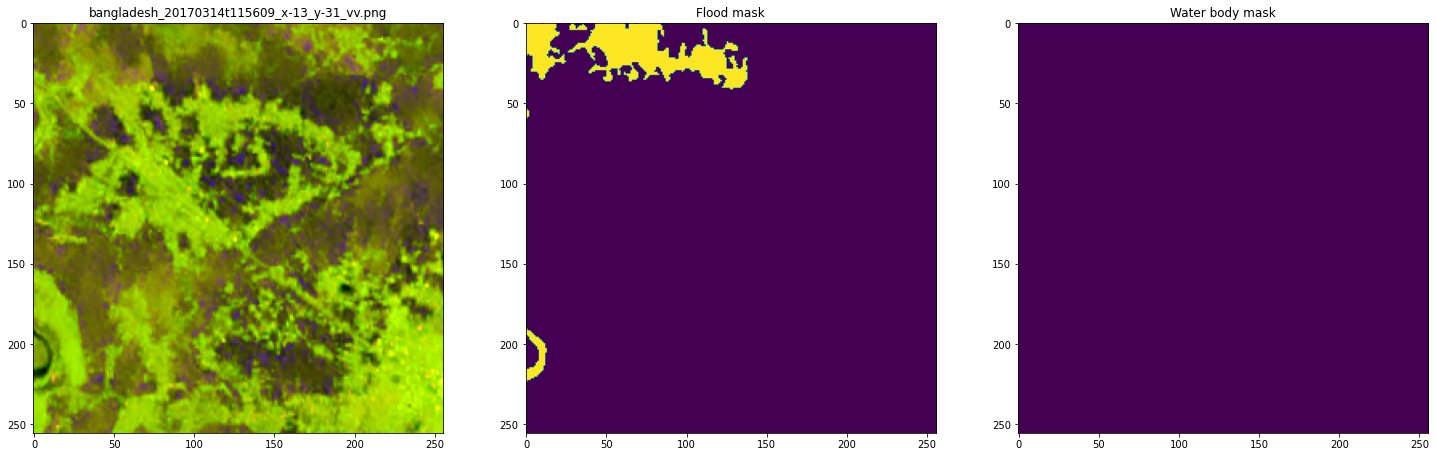

In [15]:
visualize(train_df.iloc[200])


In [19]:
def get_files(_):
    return train_df.iloc[:]

In [41]:
X = []
y = []

for i in range(len(train_df[:1200])):
    vv_image_path = train_df['vv_image_path'][i]
    vh_image_path = train_df['vh_image_path'][i]
    water_body_label_path = train_df['water_body_label_path'][i]

    # Get X
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0)
    vh_image = cv2.imread(vh_image_path, 0)
    rgb_image = s1_to_rgb(vv_image, vh_image).astype(np.float32)
    X.append(rgb_image)
    
    # Get y
    water_body_label_image = cv2.imread(water_body_label_path, 0).astype(np.float32)
    y.append(water_body_label_image)
    
       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [42]:
len(X)

1200

In [22]:
len(y)

1200

In [43]:
Xx = np.array(X)
yy = np.array(y)

In [44]:
from sklearn.model_selection import train_test_split

X_train,X_test1,y_train,y_test1 = train_test_split(Xx,yy ,test_size = 0.3 ,random_state=100)

print(X_train.shape)
print(y_train.shape)
print("***********")
print(X_test1.shape)
print(y_test1.shape)

(840, 256, 256, 3)
(840, 256, 256)
***********
(360, 256, 256, 3)
(360, 256, 256)


In [45]:
X_test,X_validate,y_test,y_validate = train_test_split(X_test1,y_test1 ,test_size = 0.5 ,random_state=100)

print(X_test.shape)
print(y_test.shape)
print("***********")
print(X_validate.shape)
print(y_validate.shape)

(180, 256, 256, 3)
(180, 256, 256)
***********
(180, 256, 256, 3)
(180, 256, 256)


In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, MaxPooling2D, Concatenate , Dropout
from tensorflow.keras.models import Model
from tensorflow import keras

def conv_block(x,num_filters):
    
    x=Conv2D(num_filters,(5,5),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    x=Conv2D(num_filters,(3,3),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    x=Conv2D(num_filters,(3,3),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    
    return x
    

def build_model():
    size=256
    num_filters=[16,32,48,64]
    
    inputs=Input(shape=(size,size,3))
    skip_x=[]
    x=inputs
    
    #Encoder
    for f in num_filters:
        x=conv_block(x,f)
        skip_x.append(x)
        x=MaxPooling2D(2,2)(x)
        

    #bottleneck
    x=conv_block(x,num_filters[-1])
    
    num_filters.reverse()
    skip_x.reverse()
    
    #Decoder
    for i,f in enumerate(num_filters):
        x=UpSampling2D((2,2))(x)
        xs=skip_x[i]
        x=Concatenate()([x,xs])
        x=conv_block(x,f)
    #output
    x=Conv2D(1,(1,1),padding='same')(x)
    x=Activation('sigmoid')(x)
    return Model(inputs,x)

    

In [47]:
model=build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 256, 256, 16) 64          conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 256, 256, 16) 0           batch_normalization_27[0][0]     
____________________________________________________________________________________________

In [48]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)
        
  


In [50]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [51]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)

schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-0, 1e-1, 1e-2])

lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

In [52]:
model.compile(optimizer=optimizer, loss=[dice_coef_loss], metrics=[dice_coef , iou])

In [53]:
epochs = 70
history = model.fit(X_train,y_train,epochs=epochs, validation_data=(X_validate , y_validate))

2022-10-11 18:15:53.392438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 660602880 exceeds 10% of free system memory.
2022-10-11 18:15:54.370912: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 660602880 exceeds 10% of free system memory.


Epoch 1/70
27/27 [==============================] - 13s 354ms/step - loss: -0.4640 - dice_coef: 1.4303 - iou: 4.8910 - val_loss: -0.4815 - val_dice_coef: 1.4935 - val_iou: 4.1990
Epoch 2/70
27/27 [==============================] - 8s 314ms/step - loss: -0.6184 - dice_coef: 1.6043 - iou: 7.3977 - val_loss: -0.4815 - val_dice_coef: 1.4935 - val_iou: 4.1990
Epoch 3/70
27/27 [==============================] - 9s 317ms/step - loss: -0.7052 - dice_coef: 1.6817 - iou: 10.7383 - val_loss: -0.4815 - val_dice_coef: 1.4935 - val_iou: 4.1990
Epoch 4/70
27/27 [==============================] - 9s 316ms/step - loss: -0.7005 - dice_coef: 1.7050 - iou: 15.3811 - val_loss: -0.4815 - val_dice_coef: 1.4935 - val_iou: 4.1990
Epoch 5/70
27/27 [==============================] - 9s 316ms/step - loss: -0.7224 - dice_coef: 1.7166 - iou: 13.2105 - val_loss: -0.4815 - val_dice_coef: 1.4935 - val_iou: 4.1990
Epoch 6/70
27/27 [==============================] - 9s 318ms/step - loss: -0.7424 - dice_coef: 1.7489 - io

Text(0, 0.5, 'iou')

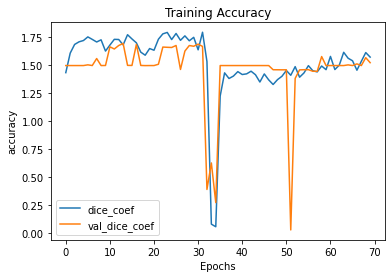

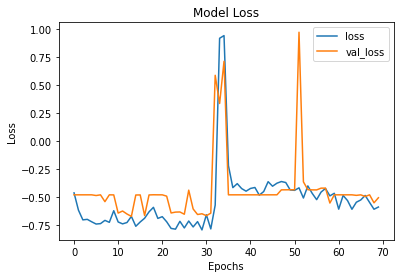

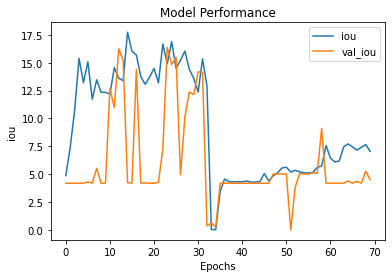

In [55]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

pd.DataFrame(history.history)[['iou', 'val_iou']].plot()
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('iou')

In [56]:
y_pred = model.predict(X_test)

In [57]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 1s 143ms/step - loss: -0.5585 - dice_coef: 1.5731 - iou: 3.7154
test loss, test acc: [-0.5584618449211121, 1.5730574131011963, 3.7153818607330322]


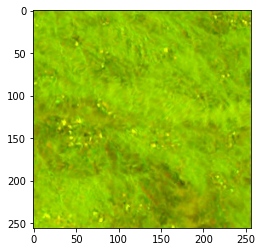

In [59]:
import cv2
cv2.imwrite('color_img.jpg', X_test[0])
img = cv2.imread("./color_img.jpg", cv2.IMREAD_COLOR)
plt.imshow(img)

Text(0.5, 1.0, 'Predicted Label')

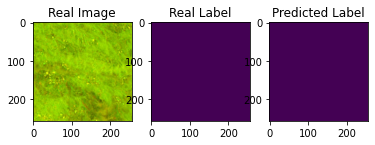

In [60]:
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Real Image')

plt.subplot(1,3,2)
plt.imshow(y_test[0])
plt.title('Real Label')


plt.subplot(1,3,3)
plt.imshow(y_pred[0])
plt.title('Predicted Label')